In [146]:
import json
import math
import os
import time
from functools import partial
from urllib.parse import urlencode
from fastparquet import write
import faiss
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

import requests
from catboost import CatBoostRanker, Pool
from faiss import read_index, write_index
from sentence_transformers import SentenceTransformer

In [2]:
# %pip install -r ./requirements.txt.

# Загрузка данных

In [3]:
start_time = time.time()

In [4]:
def download_file(pk, local_name):
    base_url = "https://cloud-api.yandex.net/v1/disk/public/resources/download?"

    final_url = base_url + urlencode(dict(public_key=pk))
    response = requests.get(final_url)
    download_url = response.json()["href"]

    download_response = requests.get(download_url)
    with open(local_name, "wb") as f:
        f.write(download_response.content)
        print(f"File {local_name} downloaded")

def download_from_yandex_disk():
    files = {
        "features.parquet": "https://disk.yandex.ru/d/W_qJitz4dZGzAg",
        "videos.parquet": "https://disk.yandex.ru/d/JXz-oDfKFgm2Dw",
        "automarkup.parquet": "https://disk.yandex.ru/d/vP0FzQHdtxsz4Q",
        "manualmarkup.csv": "https://disk.yandex.ru/d/hDztN1rgW0JNjw",
    }

    filenames, filenames_to_delete = files.keys(), []
    for filename in filenames:
        if os.path.exists(filename):
            filenames_to_delete += [filename]
    for filename in filenames_to_delete:
        del files[filename]

    print(f"Will be download {len(files)} files")
    for filename, link in files.items():
        print(f"{filename} downloading in progress")
        download_file(link, filename)
        print(f"{filename} downloaded")

In [6]:
download_from_yandex_disk()

Will be download 4 files
features.parquet downloading in progress
File features.parquet downloaded
features.parquet downloaded
videos.parquet downloading in progress
File videos.parquet downloaded
videos.parquet downloaded
automarkup.parquet downloading in progress
File automarkup.parquet downloaded
automarkup.parquet downloaded
manualmarkup.csv downloading in progress
File manualmarkup.csv downloaded
manualmarkup.csv downloaded


In [3]:
seed = 42
np.random.seed(seed)

# Формирование базы векторов

In [3]:
candidates = pd.read_parquet(
    "videos.parquet", engine="fastparquet", columns=["video_id", "video_title"]
)

In [4]:
candidates = candidates.sample(n=3_000_000, replace=False, random_state=seed)

In [5]:
candidates.head(10)

,video_id,video_title
6479006,video_24972264,Как мы снимали в публичном доме!
1521150,video_22470853,Капкейки из цветного теста
641816,video_22923068,Отзыв о рюкзаке Vikgeo | Распаковка рюкзаков V...
10116582,video_5078872,Наша ежевика на 24.06.2022г. Дальнейшие подкор...
16286594,video_19600512,КАК НАБРАТЬ МЫШЕЧНУЮ МАССУ И СИЛУ.ПОШАГОВАЯ ИН...
3199248,video_33765637,Двухсторонняя веревочка из 4-х трубочек.
5264770,video_151555,Resonant Rise - Ep 5 - Ender-Flux Thingy!! (Be...
14980251,video_20566715,"Рыбы и птицы, Бразилия"
23825112,video_4841642,Сборка интернет заказов. Вторая часть.
19458583,video_16843492,Arkona - V pogone za beloj ten'yu - Khram 2018...


In [6]:
corpus = candidates["video_title"].apply(lambda x: x.lower()).values
video_ids = candidates["video_id"].values
del candidates

In [4]:
st_model = SentenceTransformer("symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli", device="cuda")#cuda cointegrated/rubert-tiny2

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

LICENSE:   0%|          | 0.00/22.3k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.73k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/356 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [5]:
# когда прогоните один раз у вас на диске уже будет сохранен faiss индекс
# можно поставить значение True, чтобы сэкономить время на формирование индекса
use_formed_index = False

In [9]:
d = 768#312
if not use_formed_index:
    cpu_index = faiss.IndexFlatL2(d)
    cpu_index.is_trained, cpu_index.ntotal

In [6]:
# если уже есть файл ind2videoid для вашего faiss индекса - True
use_formed_id_mapping = True

if not use_formed_id_mapping:
    ind2videoid = {ind: video_id for ind, video_id in enumerate(video_ids)}
    with open("ind2videoid.json", "w+") as f:
        json.dump(ind2videoid, f, indent=4)
else:
    with open("ind2videoid.json", "r") as f:
        ind2videoid = json.load(f)

In [11]:
batch_size = 1000000
num_batches = math.ceil(len(corpus) / batch_size)

In [1]:
# %cp candidates.index candidates768.index

In [14]:
if not use_formed_index:
    try:
        for i in range(num_batches):
            # формируем батч
            start, end = i * batch_size, (i + 1) * batch_size
            corpus_batch = corpus[start:end]

            # считаем вектора для всех предложений в батче
            embeddings = st_model.encode(
                corpus_batch, show_progress_bar=True
            )#batch_size=num_batches, 

            # добавляем новые батч векторов в индекс и сохраняем его
            cpu_index.add(embeddings)
            # write_index(cpu_index, "candidates.index")

            print(f"batch: {i + 1} / {num_batches}, vectors: {cpu_index.ntotal}")

            # чистим ОЗУ
            del embeddings
        write_index(cpu_index, "candidates.index")
    except KeyboardInterrupt:
        print("Остановлено пользователем")
        try:
            del embeddings
        except:
            pass

Batches:   0%|          | 0/31250 [00:00<?, ?it/s]

batch: 1 / 3, vectors: 1000000


Batches:   0%|          | 0/31250 [00:00<?, ?it/s]

batch: 2 / 3, vectors: 2000000


Batches:   0%|          | 0/31250 [00:00<?, ?it/s]

batch: 3 / 3, vectors: 3000000


In [14]:
# чистим ОЗУ
if not use_formed_index:
    del cpu_index

In [ ]:
%pip install umap-learn plotly

In [98]:
from sklearn.manifold import TSNE
import plotly.express as px
num_docs = search_cpu_index.ntotal
embedding_dimension = search_cpu_index.d
embeddings = faiss.rev_swig_ptr(search_cpu_index.get_xb(), num_docs*embedding_dimension).reshape(num_docs, embedding_dimension)

tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(embeddings[:500])

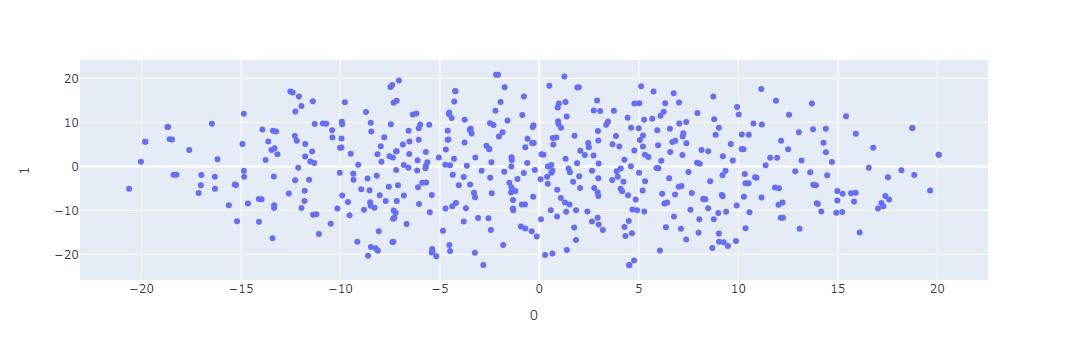

In [99]:
fig = px.scatter(
    projections, x=0, y=1
)
fig.show()

# Подбор кандидатов по базе векторов

In [59]:
automarkup = pd.read_parquet("automarkup.parquet", engine="fastparquet")

In [60]:
automarkup = automarkup[~automarkup["query"].isna()]
automarkup["query"] = automarkup["query"].apply(lambda x: x.lower().strip())

In [11]:
n = 5000
top_n = automarkup["query"].value_counts()[: int(2 * n)].index.to_list()
other = np.array(automarkup["query"].value_counts()[int(2 * n) :].index.to_list())
random_n = np.random.choice(other, size=n, replace=False).tolist()
queries = top_n + random_n
query2ind = {q: i for i, q in enumerate(queries)}

In [4]:
# когда прогоните один раз у вас на диске кандиды уже будут сохранены
# можете поставить значение True, чтобы сэкономить время
use_formed_candidates = False

In [8]:
df_test = pd.read_csv('./ground_truth.csv')
queries = df_test['query'].values

In [147]:
qembeddings = st_model.encode(queries, show_progress_bar=True)#batch_size=1000, 

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

In [10]:
search_cpu_index = read_index("candidates.index")
search_cpu_index.is_trained, search_cpu_index.ntotal

(True, 5784480)

In [11]:
qembeddings.shape

(41646, 768)

In [12]:
topk = 100
distance, faiss_ind = search_cpu_index.search(qembeddings, topk)

KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
dtype = [('distance', float), ('index', int)]
generated_cand_name = "generated_candidates.parquet"
if not use_formed_candidates:
    # distance, faiss_ind = search_cpu_index.search(qembeddings, topk)

    generated_cand = {"query": [], "video_id": [], "top":[]}
    pbar = tqdm(total=len(queries))
    for i, q in enumerate(queries):
        vids = faiss_ind[i]
        dist = distance[i]
        percentel = np.percentile(dist,2.5)
        sorted_output = np.sort(np.array([(i,j) for i,j in zip(dist, faiss_ind[i])], dtype=dtype), order='distance')
        generated_cand["video_id"] += [ind2videoid[str(v)] for v in vids]
        generated_cand["query"] += [q] * len(vids)
        if int(distance[i][0]) == 0:
            generated_cand["top"] += [1 if d<5 else 0 for d, i in sorted_output]
        else:
            mulp_dist =dist[0]*2
            generated_cand["top"] += [1 if d<percentel and d<mulp_dist else 0 for d, i in sorted_output]
        pbar.update(1)
    pbar.close()

    generated_cand = pd.DataFrame(generated_cand)

    generated_cand.to_parquet(generated_cand_name, engine="fastparquet")
    write(generated_cand_name, generated_cand)
else:
    generated_cand = pd.read_parquet(generated_cand_name, engine="fastparquet")

In [ ]:
search_cpu_index.search(qembeddings, topk)

In [17]:
search_cpu_index = read_index("candidates.index")

In [51]:
dtype = [('distance', float), ('index', int)]

def ones_predict(text, search_cpu_index, topk = 200):
    qembeddings = st_model.encode([text])
    generated_cand = {"query": [], "video_id": [], "top":[]}
    distance, faiss_ind = search_cpu_index.search(qembeddings, topk)
    sorted_output = np.sort(np.array([(i,j) for i,j in zip(distance[0], faiss_ind[0])], dtype=dtype), order='distance')
    generated_cand["video_id"] += [ind2videoid[str(v)] for v in faiss_ind[0]]
    generated_cand["query"] += [text] * len(faiss_ind[0])
    generated_cand["top"] += [1 if i<10 else 0 for i, v in enumerate(sorted_output)]
    return generated_cand
%time
predict = ones_predict("Котики", search_cpu_index, 300)

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 10.5 µs


# Формирование таргета по авторазметке

In [29]:
automarkup["target"] = [1] * automarkup.shape[0]
candidates_with_target = generated_cand.merge(
    automarkup[["query", "video_id", "target"]],
    how="left",
    left_on=["query", "video_id"],
    right_on=["query", "video_id"],
)
candidates_with_target["target"] = candidates_with_target["target"].fillna(0)

In [ ]:
# # очищаем ОЗУ
# del generated_cand
# del search_cpu_index
# del automarkup
# del st_model
# del qembeddings

In [30]:
features_parquet = pq.ParquetFile("features.parquet")
featuresArr, filter_date = [], "2023-05-02"

for batch in features_parquet.iter_batches():
    tmp = batch.to_pandas()
    featuresArr.append( tmp[tmp["report_date"] == filter_date])

features = pd.concat(featuresArr, axis=0)
features = features.drop(
    ["v_channel_reg_datetime", "v_pub_datetime","v_channel_type", "v_category"], axis=1 # "v_channel_type", "v_category",
)
# features = pd.get_dummies(features, columns=["v_channel_type", "v_category"], dtype=float)

In [124]:
# features_parquet1 = pd.read_parquet("features.parquet")

# Clickbait

In [55]:
df = pd.read_csv('./manualmarkup.csv')
df_clickbait = df.loc[df['sentiment'] == "сlickbait"]
df_exact =  df.loc[df['sentiment'] == "could_be_better"]
clickbait_dataset = []
for batch in features_parquet.iter_batches():
    clickbait_dataset.append(df_clickbait.merge(batch.to_pandas(), on='video_id',how='inner'))
    clickbait_dataset.append(df_exact.merge(batch.to_pandas(), on='video_id',how='inner'))
clickbait_dataset = pd.concat(clickbait_dataset,ignore_index=True)
clickbait_dataset.drop_duplicates(subset='video_id', inplace=True)
clickbait_dataset = pd.get_dummies(clickbait_dataset,columns=['sentiment'],dtype=int,drop_first=True)
clickbait_dataset = clickbait_dataset.drop(columns=[
    'query','query_date','report_date','v_channel_reg_datetime','v_pub_datetime','video_id','v_category','v_channel_type'])


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

y = clickbait_dataset['sentiment_сlickbait']
x = clickbait_dataset.drop(columns=['sentiment_сlickbait'])
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)
clickbait_dataset_cols = np.array(clickbait_dataset.drop(columns=['sentiment_сlickbait']).columns)

In [57]:
from catboost import CatBoostClassifier
params_clf = {
    'depth': 9, 
    'iterations': 100, 
    'learning_rate': 0.03
}
clickbait_clf = CatBoostClassifier(verbose=False, **params_clf)
clickbait_clf.fit(X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [58]:
from sklearn.metrics import confusion_matrix

ypred = clickbait_clf.predict(X_val)
cm = confusion_matrix(y_val,ypred)
print(cm)
from sklearn.metrics import classification_report
report = classification_report(y_val, ypred)
print(report)
clickbait_clf.save_model("clickbait_clf.ckpt")

[[552  39]
 [ 45  95]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       591
           1       0.71      0.68      0.69       140

    accuracy                           0.89       731
   macro avg       0.82      0.81      0.81       731
weighted avg       0.88      0.89      0.88       731



### Percent of watch

In [62]:
automarkup_percent = automarkup.drop(columns=[
    'query','datetime','is_authorized','position','position','vtop','comment','channel','tv_show','season','emotion'])#, 'target'
percent_of_watch = automarkup_percent.groupby(['video_id']).median()
percent_of_watch['percent_of_watch'] = (percent_of_watch['watchtime'] * 1000) / percent_of_watch['duration']
percent_of_watch = percent_of_watch.drop(columns=['duration','watchtime'])

# Формирование датасета с признаками

In [145]:
full_df = candidates_with_target.merge(
    features, how="inner", left_on="video_id", right_on="video_id"
)
# del features
full_df = full_df.drop("report_date", axis=1)
full_df = full_df.drop_duplicates()

NameError: name 'candidates_with_target' is not defined

In [73]:
is_clickbait = clickbait_clf.predict(full_df[clickbait_dataset_cols])
full_df['clickbait'] = is_clickbait

In [74]:
full_df = full_df.merge(
    percent_of_watch, how="left", left_on="video_id", right_on="video_id"
)

In [75]:
# views_dates = ['v_day_views']

In [76]:
# for item in views_dates:
#     col = []
#     for index, row in full_df.iterrows():
#         col.append(int(row['total_comments']/row[item] if row[item] != 0 else 0))
#     full_df[item+'_comment'] = col
#     full_df[full_df[item+'_comment'] > 1] = 1

In [ ]:
full_df.head(5)

In [78]:
groups_to_drop = []
full_df["group_id"] = full_df.groupby(["query"]).ngroup()
for group in full_df["group_id"].unique():
    part_df = full_df[full_df["group_id"] == group]
    target_sum = part_df["target"].values.sum()
    if target_sum <= 0:
        groups_to_drop += [group]
full_df = full_df[~full_df["group_id"].isin(groups_to_drop)]

In [79]:
groups = pd.Series(full_df["group_id"].unique())
permutation = groups.sample(frac=1, random_state=seed)
train_groups, val_groups, test_groups = np.split(
    permutation, [int(0.75 * len(permutation)), int(0.90 * len(permutation))]
)
groups.shape, permutation.shape

/home/jupyter/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


((177,), (177,))

In [80]:
train_df = full_df[full_df["group_id"].isin(train_groups)]
val_df = full_df[full_df["group_id"].isin(val_groups)]
test_df = full_df[full_df["group_id"].isin(test_groups)]

In [81]:

train_df = train_df.sort_values("group_id")
val_df = val_df.sort_values("group_id")
test_df = test_df.sort_values("group_id")

In [82]:
metainfo_columns = ["query", "video_id", "target", "group_id"]

X_train = train_df.drop(metainfo_columns, axis=1)
y_train, g_train = train_df["target"], train_df["group_id"]

X_val = val_df.drop(metainfo_columns, axis=1)
y_val, g_val = val_df["target"], val_df["group_id"]

X_test = test_df.drop(metainfo_columns, axis=1)
y_test, g_test = test_df["target"], test_df["group_id"]

In [83]:
train = Pool(
    data=X_train.values,
    label=y_train.values,
    group_id=g_train.values,
    feature_names=X_train.columns.to_list(),
)

val = Pool(
    data=X_val.values,
    label=y_val.values,
    group_id=g_val.values,
    feature_names=X_val.columns.to_list(),
)

test = Pool(
    data=X_test.values,
    label=y_test.values,
    group_id=g_test.values,
    feature_names=X_test.columns.to_list(),
)

# Обучение модели

In [86]:
task_type = "CPU"#
metric_period = 250

parameters = {
    # "task_type": task_type,
    "verbose": False,
    "random_seed": seed,
    "loss_function": "QueryRMSE",
    "learning_rate": 0.001,
    "l2_leaf_reg": 30,
    "iterations": 2000,
    "max_depth": 10,
    # "task_type":"GPU",
    # "devices":'0'
}

In [87]:
model = CatBoostRanker(**parameters)
model = model.fit(
    train, eval_set=val, plot=True, use_best_model=True, metric_period=metric_period
)
model.save_model("ranker.ckpt")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
grid = {'learning_rate': [0.01, 0.001, 0.005],
        'l2_leaf_reg': [5, 10, 20, 30, 40],
        "iterations": [4000, 5000, 6000],
        "max_depth": [5,9,11],
        "random_seed": [seed],
       }

model = CatBoostRanker()
grid_search_result = model.grid_search(grid, 
                                       train, 
                                       plot=True,
                                       task_type="GPU",
                           devices='0:1'
                                       )

In [ ]:
import matplotlib.pyplot as plt
feature_importance = model.get_feature_importance(train)
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')

# Измерение метрик

In [88]:
def _metrics_at(at, model, pool, metric="NDCG"):
    metric = metric + f":top={at}"
    eval_metrics = model.eval_metrics(pool, metrics=[metric])
    best_metrics = {}
    for key in eval_metrics.keys():
        best_metrics[key] = eval_metrics[key][model.best_iteration_]
    return best_metrics

metrics_train_at = partial(_metrics_at, model=model, pool=train)

metrics_val_at = partial(_metrics_at, model=model, pool=val)

metrics_test_at = partial(_metrics_at, model=model, pool=test)

In [89]:
metrics_train_at(1), metrics_train_at(5)

({'NDCG:top=1;type=Base': 0.75}, {'NDCG:top=5;type=Base': 0.8744183426288044})

In [90]:
metrics_val_at(1), metrics_val_at(5)

({'NDCG:top=1;type=Base': 0.7037037037037037},
 {'NDCG:top=5;type=Base': 0.8453135488439913})

In [93]:
metrics_test_at(1), metrics_test_at(5)

({'NDCG:top=1;type=Base': 0.6666666666666666},
 {'NDCG:top=100;type=Base': 0.8300441440631654})

In [70]:
({'NDCG:top=1;type=Base': 0.41935483870967744},
 {'NDCG:top=5;type=Base': 0.5903787493482507})

Top: 10
({'NDCG:top=1;type=Base': 0.5483870967741935},
 {'NDCG:top=5;type=Base': 0.6523261037071377})

Top:5
({'NDCG:top=1;type=Base': 0.5806451612903226},
 {'NDCG:top=5;type=Base': 0.6496098890505589})

Top:5+ clickbait
({'NDCG:top=1;type=Base': 0.5806451612903226},
 {'NDCG:top=5;type=Base': 0.6485604691631127})

Top:5+ clickbait 300 samples
({'NDCG:top=1;type=Base': 0.5882352941176471},
 {'NDCG:top=5;type=Base': 0.6784833265742837})

Top:10+ clickbait 300 samples
({'NDCG:top=1;type=Base': 0.5588235294117647},
 {'NDCG:top=5;type=Base': 0.6689172531745868})

clickbait 300 samples
({'NDCG:top=1;type=Base': 0.5588235294117647},
 {'NDCG:top=5;type=Base': 0.671673933142901})

Top first percentel + clickbait + 300 samples
({'NDCG:top=1;type=Base': 0.6176470588235294},
 {'NDCG:top=5;type=Base': 0.7746315644688175})

Top first percentel + clickbait + 300 samples with all views comments 
({'NDCG:top=1;type=Base': 0.3}, {'NDCG:top=5;type=Base': 0.5485035168455913})


SyntaxError: invalid syntax (<ipython-input-70-edf32105be66>, line 16)

In [39]:
# очищаем ОЗУ
del model
del full_df
del train_df, val_df, test_df
del train, val, test
del X_train, y_train, g_train
del X_val, y_val, g_val
del X_test, y_test, g_test

In [40]:
end_time = time.time()
total_time = (end_time - start_time) / 60
print(f"Общее время работы baseline: {int(total_time)} минут")

Общее время работы baseline: 73 минут


In [5]:
import json
import math
import os
import time
from functools import partial
from urllib.parse import urlencode
from fastparquet import write
import faiss
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

import requests
from catboost import CatBoostRanker, Pool
from faiss import read_index, write_index
from sentence_transformers import SentenceTransformer

In [6]:
st_model = SentenceTransformer("symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli", device="cuda") #cuda cointegrated/rubert-tiny2
from_file = CatBoostRanker()
from_file.load_model("ranker.ckpt")
with open("ind2videoid.json", "r") as f:
    ind2videoid = json.load(f)

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

LICENSE:   0%|          | 0.00/22.3k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.73k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/356 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [23]:
df_test = pd.read_csv('./test_dataset_submission_queries.csv')
queries = df_test['query']

In [8]:
# queries = df_test['query'].value_counts()

In [9]:
# queries = queries.keys().to_numpy()

In [24]:
qembeddings = st_model.encode(queries, show_progress_bar=True)#batch_size=1000, 

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

In [21]:
# f_dict = { q:emb for emb, q in zip(qembeddings, queries)}

In [11]:
search_cpu_index = read_index("candidates.index")
search_cpu_index.is_trained, search_cpu_index.ntotal

(True, 5784480)

In [25]:
batch_size = 500
topk = 300
num_batches = math.ceil(len(queries) / batch_size)
distance, faiss_ind = [], []
for i in range(num_batches):
    print(i)
    start, end = i * batch_size, (i + 1) * batch_size
    corpus_batch = qembeddings[start:end]
    distanceq, faiss_indq = search_cpu_index.search(corpus_batch, topk)
    distance.append(distanceq)
    faiss_ind.append(faiss_indq)

0
1
2
3


In [48]:
new = [ i[:] for i in distance]
distance = np.array(new).reshape(2000,300)
new = [ i[:] for i in faiss_ind]
faiss_ind = np.array(faiss_ind).reshape(2000,300)

In [49]:
from tqdm import tqdm
dtype = [('distance', float), ('index', int)]
generated_cand_name = "generated_candidates.parquet"

generated_cand = {"query": [], "video_id": [], "top":[]}
pbar = tqdm(total=len(queries))
for i, q in enumerate(queries):
    vids = faiss_ind[i]
    dist = distance[i]
    percentel = np.percentile(dist,2.5)
    sorted_output = np.sort(np.array([(i,j) for i,j in zip(dist, faiss_ind[i])], dtype=dtype), order='distance')
    generated_cand["video_id"] += [ind2videoid[str(v)] for v in vids]
    generated_cand["query"] += [q] * len(vids)
    if int(distance[i][0]) == 0:
        generated_cand["top"] += [1 if d<5 else 0 for d, i in sorted_output]
    else:
        mulp_dist =dist[0]*2
        generated_cand["top"] += [1 if d<percentel and d<mulp_dist else 0 for d, i in sorted_output]
    pbar.update(1)
pbar.close()
generated_cand = pd.DataFrame(generated_cand)

100%|██████████| 2000/2000 [00:03<00:00, 642.69it/s]


In [50]:
features_parquet = pq.ParquetFile("features.parquet")
featuresArr, filter_date = [], "2023-05-02"

for batch in features_parquet.iter_batches():
    tmp = batch.to_pandas()
    featuresArr.append( tmp[tmp["report_date"] == filter_date])

features = pd.concat(featuresArr, axis=0)
features = features.drop(
    ["v_channel_reg_datetime", "v_pub_datetime","v_channel_type", "v_category"], axis=1 # "v_channel_type", "v_category",
)

In [136]:
full_df = generated_cand.merge(
    features, how="left", left_on="video_id", right_on="video_id"
)
# del features
full_df = full_df.drop("report_date", axis=1)
full_df = full_df.drop_duplicates()

In [137]:
is_clickbait = clickbait_clf.predict(full_df[clickbait_dataset_cols])
full_df['clickbait'] = is_clickbait

In [144]:
full_df = full_df.merge(
    percent_of_watch, how="left", left_on="video_id", right_on="video_id"
)

In [139]:
full_df123 = full_df.copy()

In [140]:
groups_to_drop = []
full_df["group_id"] = full_df.groupby(["query"]).ngroup()
for group in full_df["group_id"].unique():
    part_df = full_df[full_df["group_id"] == group]
full_df = full_df[~full_df["group_id"].isin(groups_to_drop)]

In [69]:
# test_df = full_df[full_df["group_id"].isin(train_groups)]
test_df

In [141]:
metainfo_columns = ["query", "video_id","group_id"]

X_test = test_df.drop(metainfo_columns, axis=1)
g_train =  test_df["group_id"]

In [142]:
test = Pool(
    data=X_test.values,
    group_id=g_train.values,
    feature_names=X_test.columns.to_list(),
)

In [143]:
pred = from_file.predict(test)

CatBoostError: /src/catboost/catboost/libs/data/model_dataset_compatibility.cpp:72: Feature percent_of_watch is present in model but not in pool.

In [88]:
X_test['pred'] = pred
X_test['video_id'] = full_df['video_id']
X_test['query'] = full_df['query']
X_test

,top,total_comments,v_year_views,v_month_views,v_week_views,v_day_views,v_likes,v_dislikes,v_duration,v_cr_click_like_7_days,v_cr_click_dislike_7_days,v_cr_click_vtop_7_days,v_cr_click_long_view_7_days,v_cr_click_comment_7_days,v_cr_click_like_30_days,v_cr_click_dislike_30_days,v_cr_click_vtop_30_days,v_cr_click_long_view_30_days,v_cr_click_comment_30_days,v_cr_click_like_1_days,v_cr_click_dislike_1_days,v_cr_click_vtop_1_days,v_cr_click_long_view_1_days,v_cr_click_comment_1_days,clickbait,percent_of_watch,pred,video_id,query
583200,1,0.0,36.0,1.0,1.0,0.0,0.0,0.0,59303.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0,0.370976,0.435714,video_9184538,мужское женское
583296,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,-0.004262,video_5080311,мужское женское
583297,0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,28515.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0,NaN,-0.005476,video_26248575,мужское женское
583298,0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,29734.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0,NaN,-0.004437,video_31836928,мужское женское
583299,0,0.0,9977.0,1237.0,257.0,56.0,0.0,0.0,98616.0,0.0,0.0,0.0,0.618677,0.0,0.0,0.0,0.0,0.627324,0.0,0.0,0.0,0.0,0.517857,0.0,1,0.527298,0.074538,video_33490134,мужское женское
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223298,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,-0.004262,video_9432054,ёлки 10
223297,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,-0.004262,video_17495802,ёлки 10
223296,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,-0.004262,video_32107639,ёлки 10
223294,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,-0.004262,video_18037553,ёлки 10


In [116]:
asd = X_test.groupby(["query","video_id"]).max().sort_values('pred',ascending=False)

In [ ]:
qwe = asd.

In [122]:
vv = X_test.sort_values(by='pred', ascending=False).groupby('query').head(5).reset_index(drop=True)

In [125]:
vv[['query','video_id']].to_csv('res.csv', index=False)

In [127]:
res_df = vv[['query','video_id']]

In [108]:
from sklearn.metrics import ndcg_score
df_grd['target'] = [1] * df_grd.shape[0]
df_grd = df_grd[['query', 'video_id', 'target']].drop_duplicates()
print(df_grd['query'].value_counts())

with_target = df_solution.merge(
    df_grd,
    how='left',
    on=['query', 'video_id'],
)

with_target['target'] = with_target['target'].fillna(0.0)

y_true = np.array(
    with_target.groupby('query').agg(list)['target'].values.tolist()
)
y_score = np.array([[5.0, 4.0, 3.0, 2.0, 1.0] for _ in range(len(y_true))])

ndcg = ndcg_score(y_true, y_score)

query
музыка                                                   531
Матч тв                                                  525
Обзоры матчей                                            376
Матч                                                     364
Экстрасенсы                                              272
                                                        ... 
Ленивый плов в казане.                                     1
Ленивый плов в казане                                      1
Меч 2 сезон 3 серия                                        1
Заправка киберспортивной едой перед серьезной работой      1
Скетч-шоу VELLISSIMOO «знать и молчать?»                   1
Name: count, Length: 2000, dtype: int64
